# make a new function to make a 2D slice based on 1D Earth model (or 2D or 3D)

In [1]:
# Nobuaki Fuji Oct 2025

# breaking news! confirmed by Lorette and Stéphanie, the CMB is ellipsoidal! 
# when working with geodetic earth models, r_PREM should be corrected as a function of latitude!

using Pkg


cd(@__DIR__)
Pkg.activate("../..")
ParamFile = "../test/testparam.csv"
include("../src/batchRevise.jl") 

myInclude("../src/DSM1D.jl")
using .DSM1D

  Activating project at `~/Documents/Github/flexibleDSM`
┌ Info: Including with Revise: ../src/DSM1D.jl
└ @ Main /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/src/batchRevise.jl:25


  0.005722 seconds (2.17 k allocations: 108.156 KiB, 76.14% compilation time)


In [2]:
using Geodesy, Interpolations, StaticArrays, GMT, LinearAlgebra

In [3]:
DSM1D.my1DDSMmodel.averagedPlanetRadiusInKilometer

6371.0

In [4]:
# Example 1-D model (toy). Replace with your actual model arrays.
# r_model in meters from Earth center (0..R_ref), assume sorted ascending
R_ref = DSM1D.my1DDSMmodel.averagedPlanetRadiusInKilometer*1.e3                   # model reference radius (m)
r_model = collect(0.0:1000.0:R_ref)  # example radius grid
v_model = 5000 .- 0.5 .* (R_ref .- r_model) ./ 1000  # dummy profile

6372-element Vector{Float64}:
 1814.5
 1815.0
 1815.5
 1816.0
 1816.5
 1817.0
 1817.5
 1818.0
 1818.5
 1819.0
    ⋮
 4996.0
 4996.5
 4997.0
 4997.5
 4998.0
 4998.5
 4999.0
 4999.5
 5000.0

In [5]:
# create an interpolator in radius space (ensure interpolation domain covers used r)
itp = LinearInterpolation(r_model, v_model; extrapolation_bc=Flat())

6372-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Flat()) with element type Float64:
 1814.5
 1815.0
 1815.5
 1816.0
 1816.5
 1817.0
 1817.5
 1818.0
 1818.5
 1819.0
    ⋮
 4996.0
 4996.5
 4997.0
 4997.5
 4998.0
 4998.5
 4999.0
 4999.5
 5000.0

In [70]:
itp(2000.2)

1815.5000999999997

In [76]:
import Base: +,-,/
struct GeoPoint
    lat::Float64 # in degree
    lon::Float64 # in degree
    alt::Float64 # in metre
    ecef::SVector{3,Float64}
    radius::Float64 # in metre
    #effectiveRadius::Float64 # in metre (useful to get values from 1D averaged model)
end

function GeoPoint(lat::Float64, lon::Float64; alt=0.0, ell=wgs84)
    lla = LLA(lat,lon, alt) # be careful LLA uses degrees by default!!
    ecef_coords = ECEF(lla,ell)
    radius = norm([ecef_coords.x,ecef_coords.y,ecef_coords.z])
    GeoPoint(lat, lon, alt, SVector(ecef_coords.x, ecef_coords.y, ecef_coords.z),radius)
end


function GeoPoint(ecef::SVector{3,Float64}; ell=wgs84)
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end

function +(a::GeoPoint,b::GeoPoint; ell=wgs84)
    ecef=a.ecef + b.ecef
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end

function -(a::GeoPoint,b::GeoPoint; ell=wgs84)
    ecef=a.ecef - b.ecef
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end

function /(a::GeoPoint,c::Real; ell=wgs84)
    ecef=a.ecef / c
    lla = LLA(ECEF(ecef...),ell)
    radius = norm(ecef)
    GeoPoint(lla.lat,lla.lon,lla.alt,ecef,radius)
end


function effectiveRadius(a::GeoPoint,r0::Float64; ell=wgs84)
    radiusPlanetHere = GeoPoint(a.lat,a.lon).radius 
    ratio = r0/radiusPlanetHere
    return a.radius*ratio
end




effectiveRadius (generic function with 1 method)

In [7]:
p1 = GeoPoint(48.8566,2.3522) # Paris
p2 = GeoPoint(42.8,1.5) # Tarascon (à peu près)
#topographyFromGeoPoint(p1)
@show GeoPoint(p1.ecef)
@show p0 = (p1 + p2)/2.0


GeoPoint(p1.ecef) = GeoPoint(48.8566, 2.3522000000000003, 7.047140324999535e-10, [4.200914795649138e6, 172559.77631070156, 4.780081341967356e6], 6.366053693814456e6)
p0 = (p1 + p2) / 2.0 = GeoPoint(45.82989800475024, 1.9029714540760907, -8978.352692728113, [4.443193158578102e6, 147626.58304377226, 4.545653677986095e6], 6.358201507709939e6)


GeoPoint(45.82989800475024, 1.9029714540760907, -8978.352692728113, [4.443193158578102e6, 147626.58304377226, 4.545653677986095e6], 6.358201507709939e6)

In [8]:
# pre-definition of x-axis vector p1->p2 (normally this is not the one we want)
p2_1 = p2-p1
x_axis_tentative = (p2_1/p2_1.radius).ecef


3-element SVector{3, Float64} with indices SOneTo(3):
  0.7166970175507206
 -0.07375625720924696
 -0.693473431038555

In [44]:
# definition of z-axis vector centre -> p0

z_axis = (p0/p0.radius).ecef

3-element SVector{3, Float64} with indices SOneTo(3):
 0.698812888076966
 0.023218292604404035
 0.7149275895823759

In [10]:
# y-axis: complete right-handed system
y_axis = normalize(cross(z_axis, x_axis_tentative))

3-element SVector{3, Float64} with indices SOneTo(3):
  0.036629318622305354
  0.9970002078796852
 -0.06818268478968828

In [11]:
x_axis = cross(y_axis, z_axis)  # now perfectly orthogonal

3-element SVector{3, Float64} with indices SOneTo(3):
  0.7143660409585519
 -0.07383424934541309
 -0.6958661244440657

In [12]:
#Rotation matrix
R = SMatrix{3,3,Float64}(
    x_axis[1], y_axis[1], z_axis[1],
    x_axis[2], y_axis[2], z_axis[2],
    x_axis[3], y_axis[3], z_axis[3]
)

3×3 SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
 0.714366   -0.0738342  -0.695866
 0.0366293   0.997      -0.0681827
 0.698813    0.0232183   0.714928

In [48]:
p_2D_to_ECEF(x_2D,z_2D,pOrigin::SVector{3,Float64},R::SMatrix{3,3,Float64}) = pOrigin+R'*SVector(x_2D,0.e0,z_2D)

p_2D_to_ECEF (generic function with 1 method)

In [49]:
p_ECEF_to_2D(p_3D::SVector{3,Float64},pOrigin::SVector{3,Float64},R::SMatrix{3,3,Float64}) = R * (p_3D - pOrigin)

p_ECEF_to_2D (generic function with 1 method)

In [51]:
p_ECEF_to_2D(p0.ecef, p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
 338046.62854124676
     -2.8438589548976056e-11
   1129.5315985638524

In [52]:
p0_0_above=p_2D_to_ECEF(0,0,p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
      4.200914795649138e6
 172559.77631070156
      4.780081341967356e6

In [53]:
p0_1m_above=p_2D_to_ECEF(0,1,p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
      4.200915494462026e6
 172559.79952899416
      4.780082056894946e6

In [54]:
p_ECEF_to_2D(p0_1m_above, p1.ecef,R)

3-element SVector{3, Float64} with indices SOneTo(3):
 -8.852265046769912e-12
 -5.413994677125502e-12
  0.9999999999047554

In [55]:
Δx = 500 # in metre
Δz = 500

altMax = 5000 # in metre
altMin = -400.e3 # in metre

-400000.0

In [56]:
# since p1 and p2 can be even out of the solid Earth or inside the Earth
# I define that p1 and p2 should be the left and right limits

In [57]:
leftLimit = 0 # in metre so x is always non-negative
rightLimit = p2_1.radius


676097.0312306838

In [58]:
@show Nx = Int64((rightLimit-leftLimit) ÷ Δx+1) 
@show Nz = Int64((altMax-altMin) ÷ Δz + 1 ) 

811

In [59]:
DSM1D.my1DDSMmodel.C_Qκ

12×4 Matrix{Float64}:
  1327.7  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0
 57823.0  0.0  0.0  0.0

In [60]:
myRadiiArray=[5330.0,7330.0]

2-element Vector{Float64}:
 5330.0
 7330.0

In [61]:
radii,params=DSM1D.compute1DseismicParamtersFromPolynomialCoefficientsWithGivenRadiiArray(DSM1D.my1DDSMmodel,myRadiiArray,"below")
params.Vph

2-element Vector{Float64}:
 11.530300555810514
  0.0

In [71]:
allGridsInGeoPoints=Array{GeoPoint,2}(undef,Nx,Nz)
effectiveRadii=Array{Float64,2}(undef,Nx,Nz)
seismicModel2D=(ρ=zeros(Float64,Nx,Nz),Vpv=zeros(Float64,Nx,Nz),Vph=zeros(Float64,Nx,Nz),Vsv=zeros(Float64,Nx,Nz),Vsh=zeros(Float64,Nx,Nz),Qμ=zeros(Float64,Nx,Nz),Qκ=zeros(Float64,Nx,Nz),QμPower=zeros(Float64,Nx,Nz),QκPower=zeros(Float64,Nx,Nz),η=zeros(Float64,Nx,Nz))

for iXZ in CartesianIndices(allGridsInGeoPoints)
    ix, iz = Tuple(iXZ)
    x = leftLimit+(ix-1)*Δx
    z = altMin+(iz-1)*Δz 
    tmpGeoPoint=GeoPoint(p_2D_to_ECEF(x,z,p1.ecef,R))
    allGridsInGeoPoints[iXZ]=tmpGeoPoint
    effectiveRadii[iXZ]=effectiveRadius(tmpGeoPoint,DSM1D.my1DDSMmodel.averagedPlanetRadiusInKilometer*1.e3 )
end


In [63]:
allGridsInGeoPoints[1,1]

GeoPoint(49.07203149611877, 2.3842115926789575, -399320.47067895037, [3.921389640418352e6, 163272.45926893994, 4.4941103061344065e6], 5.966655851617352e6)

In [64]:
effectiveRadii[200,1]

5.966223685230306e6

In [65]:
minimum(effectiveRadii)

5.960617361368072e6

In [66]:
# make a regular grid for the necessary radii
NradiusNodes = 100
tmpNradiusNodes = NradiusNodes
if NradiusNodes === 1
    tmpNradiusNodes = 1
end

ΔradiusIncrementInKm = (maximum(effectiveRadii)-minimum(effectiveRadii))/(tmpNradiusNodes-1) *1.e-3
linearRadiiInKm =(collect(1:1:NradiusNodes) .- 1)*ΔradiusIncrementInKm .+ minimum(effectiveRadii)*1.e-3


100-element Vector{Float64}:
 5960.617361368072
 5964.813104134159
 5969.008846900248
 5973.204589666335
 5977.400332432422
 5981.596075198509
 5985.791817964598
 5989.987560730685
 5994.183303496772
 5998.37904626286
    ⋮
 6342.429953082038
 6346.625695848125
 6350.821438614213
 6355.017181380301
 6359.212924146388
 6363.408666912475
 6367.604409678564
 6371.800152444651
 6375.995895210738

In [67]:
_,params=DSM1D.compute1DseismicParamtersFromPolynomialCoefficientsWithGivenRadiiArray(DSM1D.my1DDSMmodel,linearRadiiInKm,"below")

([5960.617361368072, 5964.813104134159, 5969.008846900248, 5973.204589666335, 5977.400332432422, 5981.596075198509, 5985.791817964598, 5989.987560730685, 5994.183303496772, 5998.37904626286  …  6338.234210315951, 6342.429953082038, 6346.625695848125, 6350.821438614213, 6355.017181380301, 6359.212924146388, 6363.408666912475, 6367.604409678564, 6371.800152444651, 6375.995895210738], (ρ = [3.7368328538199105, 3.7315446768833036, 3.726256499946695, 3.5419471101262645, 3.539441584564566, 3.536936059002868, 3.5344305334411694, 3.531925007879471, 3.5294194823177727, 3.5269139567560743  …  3.379839015417166, 3.380295008556585, 2.9, 2.9, 2.9, 2.6, 2.6, 2.6, 0.0, 0.0], Vpv = [9.187071020436687, 9.165590740495652, 9.144110460554607, 8.901001925116734, 8.892929911381112, 8.884857897645487, 8.876785883909863, 8.86871387017424, 8.860641856438615, 8.85256984270299  …  8.012578124322795, 8.017331674987624, 6.8, 6.8, 6.8, 5.8, 5.8, 5.8, 0.0, 0.0], Vph = [9.187071020436687, 9.165590740495652, 9.1441104

In [68]:
params.ρ

100-element Vector{Float64}:
 3.7368328538199105
 3.7315446768833036
 3.726256499946695
 3.5419471101262645
 3.539441584564566
 3.536936059002868
 3.5344305334411694
 3.531925007879471
 3.5294194823177727
 3.5269139567560743
 ⋮
 3.380295008556585
 2.9
 2.9
 2.9
 2.6
 2.6
 2.6
 0.0
 0.0

In [75]:
# now I need to use GMT.jl to get the topography

lats = [p.lat for p in allGridsInGeoPoints]
lons = [p.lon for p in allGridsInGeoPoints]

lat_min, lat_max = extrema(lats)
lon_min, lon_max = extrema(lons)
lat_min, lat_max,lon_min,lon_max

(42.60952377524328, 49.07203149611877, 1.4743871429132926, 2.3842115926789575)

In [ ]:
using GMT

region = [lon_min, lon_max, lat_min, lat_max]
region = [-10,20,35,60]
precision = "@earth_relief_01m"
# resolution can be @earth_relief_01m (≈2 km), @earth_relief_03m, or coarser like 10m, 30m, etc.
topo = GMT.grdcut(precision, region=region)

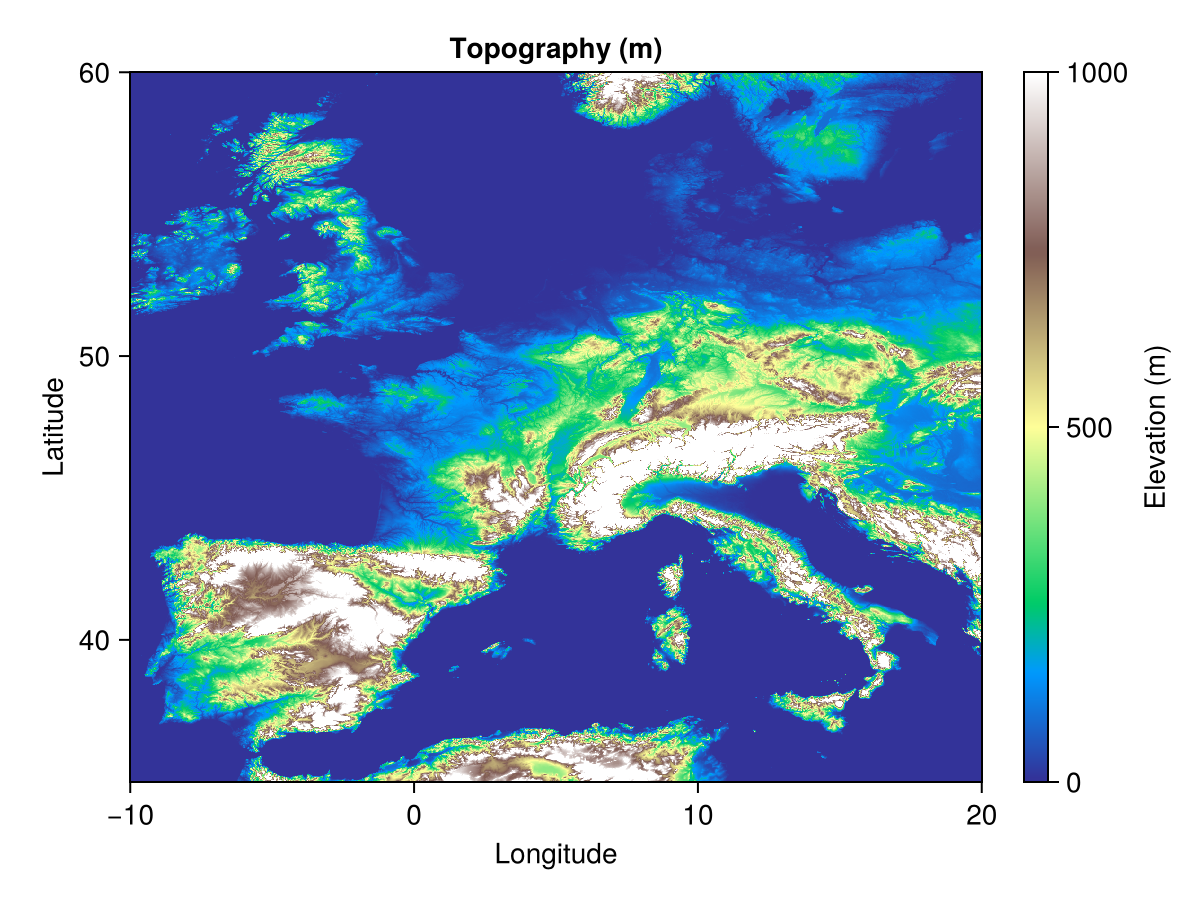

In [158]:
using CairoMakie



fig, ax, hm = heatmap(
    topo.x,topo.y,topo.z';
    colormap = :terrain,
    colorrange=(0,1000),
    axis = (aspect = DataAspect(), xlabel = "Longitude", ylabel = "Latitude", title = "Topography (m)")
)
Colorbar(fig[1,2], hm, label="Elevation (m)")
fig

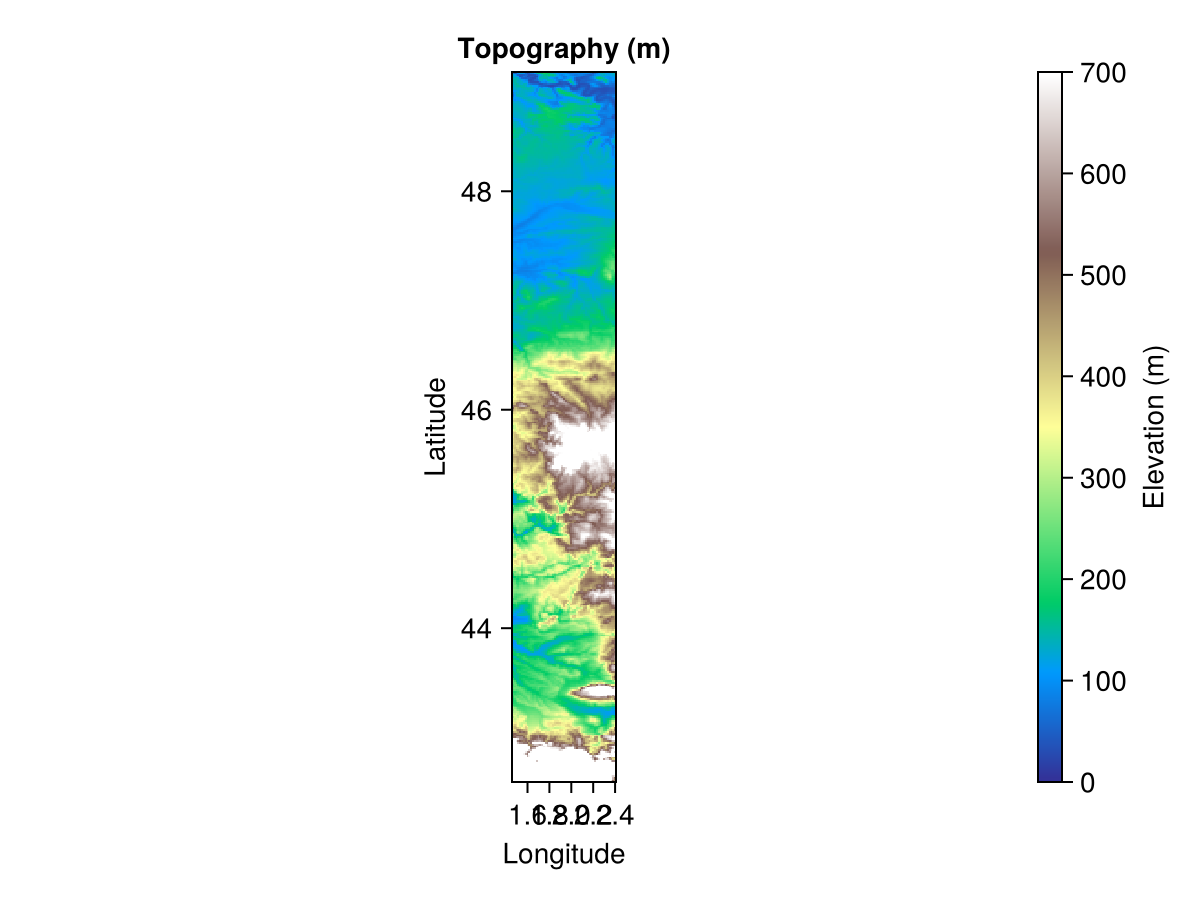

In [193]:
using GMT,CairoMakie

region = [lon_min, lon_max, lat_min, lat_max]

precision = "@earth_relief_01m"
# resolution can be @earth_relief_01m (≈2 km), @earth_relief_03m, or coarser like 10m, 30m, etc.
topo = GMT.grdcut(precision, region=region)

fig, ax, hm = heatmap(
    topo.x,topo.y,topo.z';
    colormap = :terrain,
    colorrange=(0,700),
    axis = (aspect = DataAspect(), xlabel = "Longitude", ylabel = "Latitude", title = "Topography (m)")
)
Colorbar(fig[1,2], hm, label="Elevation (m)")
fig

In [194]:
# resolution can be @earth_relief_01m (≈2 km), @earth_relief_03m, or coarser like 10m, 30m, etc.

In [195]:
size(topo.x),size(topo.y),size(topo.z')


((57,), (390,), (57, 390))

# I need to : 
add local coordinates and normals at each point as options to GeoPoint


In [179]:

# Extract coordinates from GeoPoints
lons = [p.lon for p in allGridsInGeoPoints[:]]
lats = [p.lat for p in allGridsInGeoPoints[:]]


1097283-element Vector{Float64}:
 49.07203149611877
 49.06726941612928
 49.062507279066956
 49.0577450849989
 49.052982833992175
 49.04822052611393
 49.04345816143126
 49.03869574001129
 49.03393326192114
 49.029170727227935
  ⋮
 42.83784917189433
 42.83337487135047
 42.828900599052744
 42.824426355056865
 42.81995213941853
 42.81547795219343
 42.811003793437244
 42.806529663205666
 42.8020555615544

In [184]:

# Query the topography via grdtrack using the file path
topo_vals = GMT.grdtrack(lons, lats; G=tmpfile,show=false)

String[]

In [183]:


# Reshape back to 2D
Nx, Nz = size(allGridsInGeoPoints)
topo_vals_2D = reshape(topo_vals, Nx, Nz)


DimensionMismatch: DimensionMismatch: parent has 0 elements, which is incompatible with size (1353, 811)